In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fmin_cg

## Load in Data

In [3]:
matrix = scipy.io.loadmat("ex5data1.mat")

In [444]:
# view headers
matrix.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [539]:
X_train = matrix['X'] # 12x1
y_train = matrix['y'] # 12x1

X_test = matrix['Xtest'] # 21x1
y_test = matrix['ytest'] # 21x1

Xval = matrix['Xval'] # 21x1
yval = matrix['yval'] # 21x1

## Visualize Data

Text(0.5, 0, 'Change in water level')

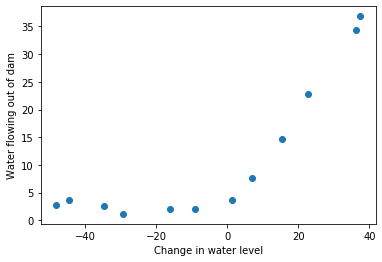

In [499]:
plt.scatter(X_train, y_train)
plt.ylabel("Water flowing out of dam")
plt.xlabel("Change in water level")

## Implement Regularized Cost Function

In [540]:
lam = 0

In [541]:
# add bias term
x_ones = np.ones(len(X_train))
X_train = np.column_stack((x_ones, X))

In [542]:
def linReg_cost(theta, X, y, lam):
    m = len(X) # number of samples
    
    h = X.dot(theta).reshape(-1,1) # predictions
    sq_errors = np.square(h-y) 
    
    J_first = 1/(2*m) * sum(sq_errors)      
    J_reg = lam/(2*m) * sum(theta[1:]**2) # regularization term    
    J = J_first + J_reg # cost
    
    return J

In [543]:
def linReg_grad(theta, X, y, lam):
    m = len(X) # number of samples
    grad = np.zeros(theta.size).reshape(-1,1)
    
    h = X.dot(theta).reshape(-1,1) # predictions
    errors = h-y

    grad[0] = 1/m * (X[:, 0].T.dot(errors))
    grad[1:] = 1/m * (X[:, 1:].T.dot(errors)) + (lam/m * theta[1:])
    
    return grad

#### Check cost

In [544]:
# should get 303.993
J = linReg_cost(np.ones(X_train.shape[1]).reshape(-1,1), X_train, y_train, lam)
print(J)

[303.95152555]


#### Check gradient 

In [545]:
'''Gradient should equal:
    [-15.30 ; 598.25]
'''
grad = linReg_grad(np.ones(X_train.shape[1]).reshape(-1,1), X_train, y_train, lam)
print(grad)

[[-15.30301567]
 [598.16741084]]


## Train Model

In [506]:
def train_linReg(X_train, y_train, lam):
    theta_init = np.ones(X_train.shape[1]).reshape(-1,1) # initial theta
    
    params_opt = fmin_cg(linReg_cost, 
                     theta_init,
                     #fprime = linReg_grad,
                     args = (X_train,y_train,lam),
                     maxiter=200)
    
    return params_opt

In [507]:
# get optimized theta
theta = train_linReg(X_train, y_train, lam)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 17
         Function evaluations: 112
         Gradient evaluations: 28


In [508]:
"""Opt Theta:
    [13.088; 0.368]
"""
print(params_opt)

[13.08790734  0.36777925]


## Plot Best Fit Line

Text(0.5, 1.0, 'Fitting:  y = 13.0879 + 0.3678 * x')

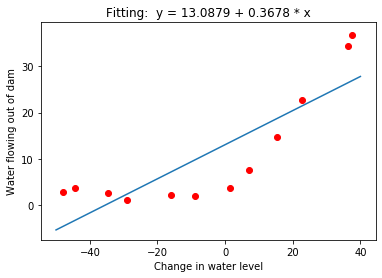

In [509]:
x_plot = np.linspace(-50, 40, 500)
y_plot = params_opt[0] + params_opt[1]*x_plot

plt.plot(x_plot, y_plot)

plt.scatter(X_train[:, 1:], y_train, color='r')
plt.ylabel("Water flowing out of dam")
plt.xlabel("Change in water level")
plt.title("Fitting:  y = %.4f + %.4f * x" % (params_opt[0], params_opt[1]))

## Learning Curve
  - This will help us diagnose bias and variance problems

In [546]:
def learning_curve(X, y, Xval, yval, lam):
    m = len(X) # number of samples
    curve_lam = 0
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        theta = train_linReg(X[:i+1, :], y[:i+1], lam)
        
        # get train errors
        J = linReg_cost(theta, X[:i+1, :], y[:i+1], curve_lam)
        error_train[i] = J
        
        # get validation errors
        J = linReg_cost(theta, Xval, yval, curve_lam)
        error_val[i] = J
        
    return error_train, error_val

In [547]:
x_ones = np.ones(len(Xval))
Xval = np.column_stack((x_ones, Xval))

In [548]:
error_train, error_val = learning_curve(X_train, y_train, Xval, yval, lam)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 3.286595
         Iterations: 4
         Function evaluations: 36
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 2.842678
         Iterations: 20
         Function evaluations: 128
         Gradient evaluations: 32
         Current function value: 13.154049
         Iterations: 4
         Function evaluations: 219
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 19.443963
         Iterations: 4
         Function evaluations: 32
         Gradient evaluations: 8
Optimizatio

Text(0, 0.5, 'Error')

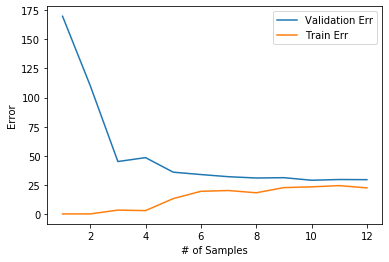

In [549]:
x_plot = [i for i in range(1,13)]

plt.plot(x_plot, error_val, label='Validation Err')
plt.plot(x_plot, error_train, label='Train Err')
plt.legend(loc="upper right")
plt.xlabel("# of Samples")
plt.ylabel("Error")

## Polynomial Regression

In [623]:
def poly_features(X, p):
    X_poly = np.zeros((X.size, p))
    m = len(X)
    
    for i in range(m):
        for j in range(p):
            X_poly[i, j] = X[i]**(j+1)
            
    return X_poly
    

In [624]:
# map train, test, and val set to 8-degree polynomial
p = 8 

X_poly_train = poly_features(X_train[:, 1:], p)
X_poly_test = poly_features(X_test, p)
X_poly_val = poly_features(Xval[:, 1:], p)

#### normalize each

In [625]:
def feature_normalize(X):
    mu = X.mean(axis=0)
    sigma = np.std(X, axis=0)
    
    X_norm = X - mu    
    X_norm = X_norm / sigma   
    
    return X_norm, mu, sigma

In [626]:
# train set
X_poly_train, mu, sigma = feature_normalize(X_poly_train)
X_poly_train = np.column_stack((np.ones(len(X_poly_train)), X_poly_train))

In [628]:
# test set
X_poly_test = X_poly_test - mu
X_poly_test = X_poly_test/sigma
X_poly_test = np.column_stack((np.ones(len(X_poly_test)), X_poly_test))

# val set
X_poly_val = X_poly_val - mu
X_poly_val = X_poly_val/sigma
X_poly_val = np.column_stack((np.ones(len(X_poly_val)), X_poly_val))

#### Calculate optimum theta and errors

In [629]:
theta = train_linReg(X_poly_train, y_train, lam)

         Current function value: 0.090154
         Iterations: 200
         Function evaluations: 4268
         Gradient evaluations: 388


In [641]:
error_train, error_val = learning_curve(X_poly_train, y_train, X_poly_val, yval, lam)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 33
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 55
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 187
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 75
         Function evaluations: 1397
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 473
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 109
         Function evaluations: 2277

#### Plot learning curve

Text(0, 0.5, 'Error')

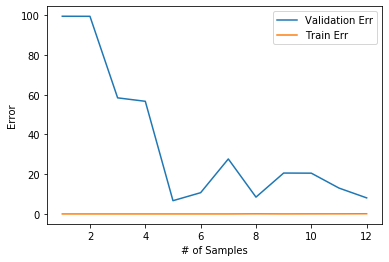

In [643]:
# learning curve
x_plot = [i for i in range(1,13)]

plt.plot(x_plot, error_val, label='Validation Err')
plt.plot(x_plot, error_train, label='Train Err')
plt.legend(loc="upper right")
plt.xlabel("# of Samples")
plt.ylabel("Error")

## Cross Validation Curve

In [650]:
def validation_curve(X, y, Xval, yval):
    lam_set = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    
    m = len(X)
    error_train = np.zeros(len(lam_set))
    error_val = np.zeros(len(lam_set))
    
    curve_lam = 0
    for i in range(len(lam_set)):
        lam = lam_set[i]
        theta = train_linReg(X, y, lam)
        
        # train error
        J = linReg_cost(theta, X, y, curve_lam)
        error_train[i] = J
        
        # val error
        J = linReg_cost(theta, Xval, yval, curve_lam)
        error_val[i] = J
        
    return lam_set, error_train, error_val

In [651]:
lam_set, error_train, error_val = validation_curve(X_poly_train, y_train, X_poly_val, yval)

         Current function value: 0.090154
         Iterations: 200
         Function evaluations: 4268
         Gradient evaluations: 388
         Current function value: 0.169897
         Iterations: 200
         Function evaluations: 4136
         Gradient evaluations: 376
         Current function value: 0.244408
         Iterations: 200
         Function evaluations: 4004
         Gradient evaluations: 364
         Current function value: 0.371283
         Iterations: 200
         Function evaluations: 4147
         Gradient evaluations: 377
Optimization terminated successfully.
         Current function value: 0.636703
         Iterations: 87
         Function evaluations: 1870
         Gradient evaluations: 170
Optimization terminated successfully.
         Current function value: 1.360572
         Iterations: 90
         Function evaluations: 1826
         Gradient evaluations: 166
Optimization terminated successfully.
         Current function value: 2.917649
         Iteration

Text(0, 0.5, 'Error')

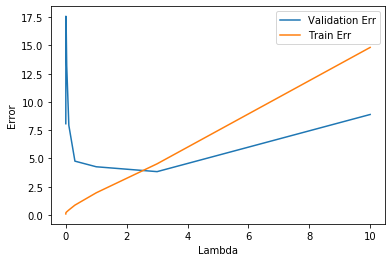

In [653]:
# learning curve
plt.plot(lam_set, error_val, label='Validation Err')
plt.plot(lam_set, error_train, label='Train Err')
plt.legend(loc="upper right")
plt.xlabel("Lambda")
plt.ylabel("Error")